In [1]:
import pickle
import numpy as np
import os
import h5py
import openslide
import torch
import pandas as pd
from prototype_visualization_utils import get_panther_encoder, visualize_categorical_heatmap, get_mixture_plot, get_default_cmap
from mmp_visualization_utils import plot_pathomic_correspondence
import sys
sys.path.append('../')
from mil_models.tokenizer import PrototypeTokenizer

2025-03-07 14:00:27.171748: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-07 14:00:27.331752: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741327227.406047   21257 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741327227.424502   21257 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-07 14:00:27.581027: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [2]:
proto_path = "/home/zhuzhuwen/code/MMP_NETWORK/src/splits/survival/TCGA_KIRC_overall_survival_k=3/prototypes/prototypes_c16_extracted-vit_large_patch16_224.dinov2.cnn_mass100k_faiss_num_1.0e+05.pkl"
mmp_result_pkl_path = "/home/zhuzhuwen/code/MMP_NETWORK/src/results/KIRC_survival::PANTHER_default::vit_large_patch16_224.dinov2.uni_mass100k/KIRC_survival/k=3/TCGA_KIRC_overall_survival::PANTHER_default::feats_h5/TCGA_KIRC_overall_survival::PANTHER_default::feats_h5::24-12-22-16-15-29/test_results.pkl"

In [3]:
### Loading PANTHER Encoder
panther_encoder = get_panther_encoder(in_dim=1024, p=16, proto_path=proto_path, config_dir='../configs')
panther_encoder.panther.H = 1

In [4]:
### Loading results pkl file from MMP training
results = pickle.load(open(mmp_result_pkl_path, 'rb'))
for split, split_results in results.items():
    print(split)
    # for k, v in split_results.items():
    #     print(f'\t{k}: {v.shape}')

### which samples to visualize
sample_ids = ["TCGA-BP-4163"]

sample_id = sample_ids[0]
idxs = [np.where(results['sample_ids']==sample_id)[0][0] for sample_id in sample_ids]
sampleid2idx = dict(zip(sample_ids, idxs))

### color map
color_map = get_default_cmap(16)
for k,v in get_default_cmap(16).items():
    color_map[15-k] = v
color_map_hex = get_default_cmap(16, return_hex=True)
for k,v in get_default_cmap(16, return_hex=True).items():
    color_map_hex[15-k] = v

display(color_map, color_map_hex)

FileNotFoundError: [Errno 2] No such file or directory: '/home/zhuzhuwen/code/MMP_NETWORK/src/results/KIRC_survival::PANTHER_default::vit_large_patch16_224.dinov2.uni_mass100k/KIRC_survival/k=3/TCGA_KIRC_overall_survival::PANTHER_default::feats_h5/TCGA_KIRC_overall_survival::PANTHER_default::feats_h5::24-12-22-16-15-29/test_results.pkl'

out
torch.Size([1, 32784])
tensor(0.0601)
tensor(0.0847)
==========global_cluster_labels==========
类别: 14, 数量: 36402, 比例: 86.88%
类别: 5, 数量: 4383, 比例: 10.46%
类别: 11, 数量: 281, 比例: 0.67%
类别: 10, 数量: 4, 比例: 0.01%
类别: 12, 数量: 12, 比例: 0.03%
类别: 13, 数量: 45, 比例: 0.11%
类别: 0, 数量: 122, 比例: 0.29%
类别: 9, 数量: 3, 比例: 0.01%
类别: 8, 数量: 629, 比例: 1.50%
类别: 15, 数量: 7, 比例: 0.02%
类别: 6, 数量: 7, 比例: 0.02%
类别: 3, 数量: 1, 比例: 0.00%
类别: 1, 数量: 1, 比例: 0.00%

Creating heatmap for: 
Top Left:  (0, 0) Bottom Right:  (71985, 76028)
Width: 2249, Height: 2375
Original Patch Size / Scaled Patch Size: (256, 256) / [8 8]
vis_level:  2
downsample:  32
region_size:  (2249, 2375)
total of 41897 patches


100%|██████████| 41897/41897 [00:01<00:00, 25159.83it/s]


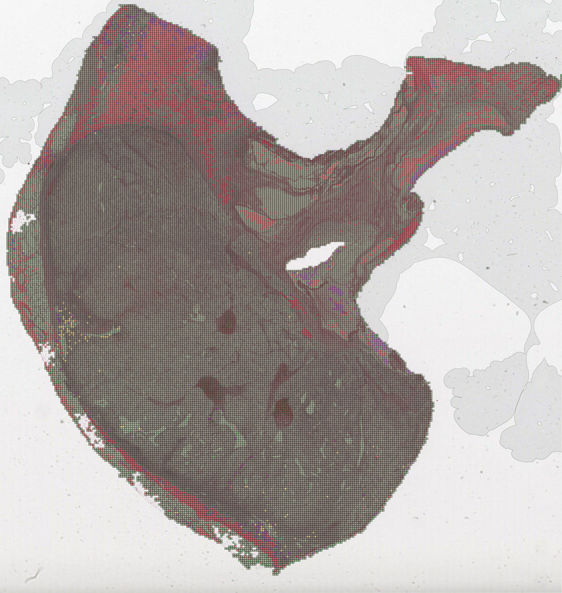

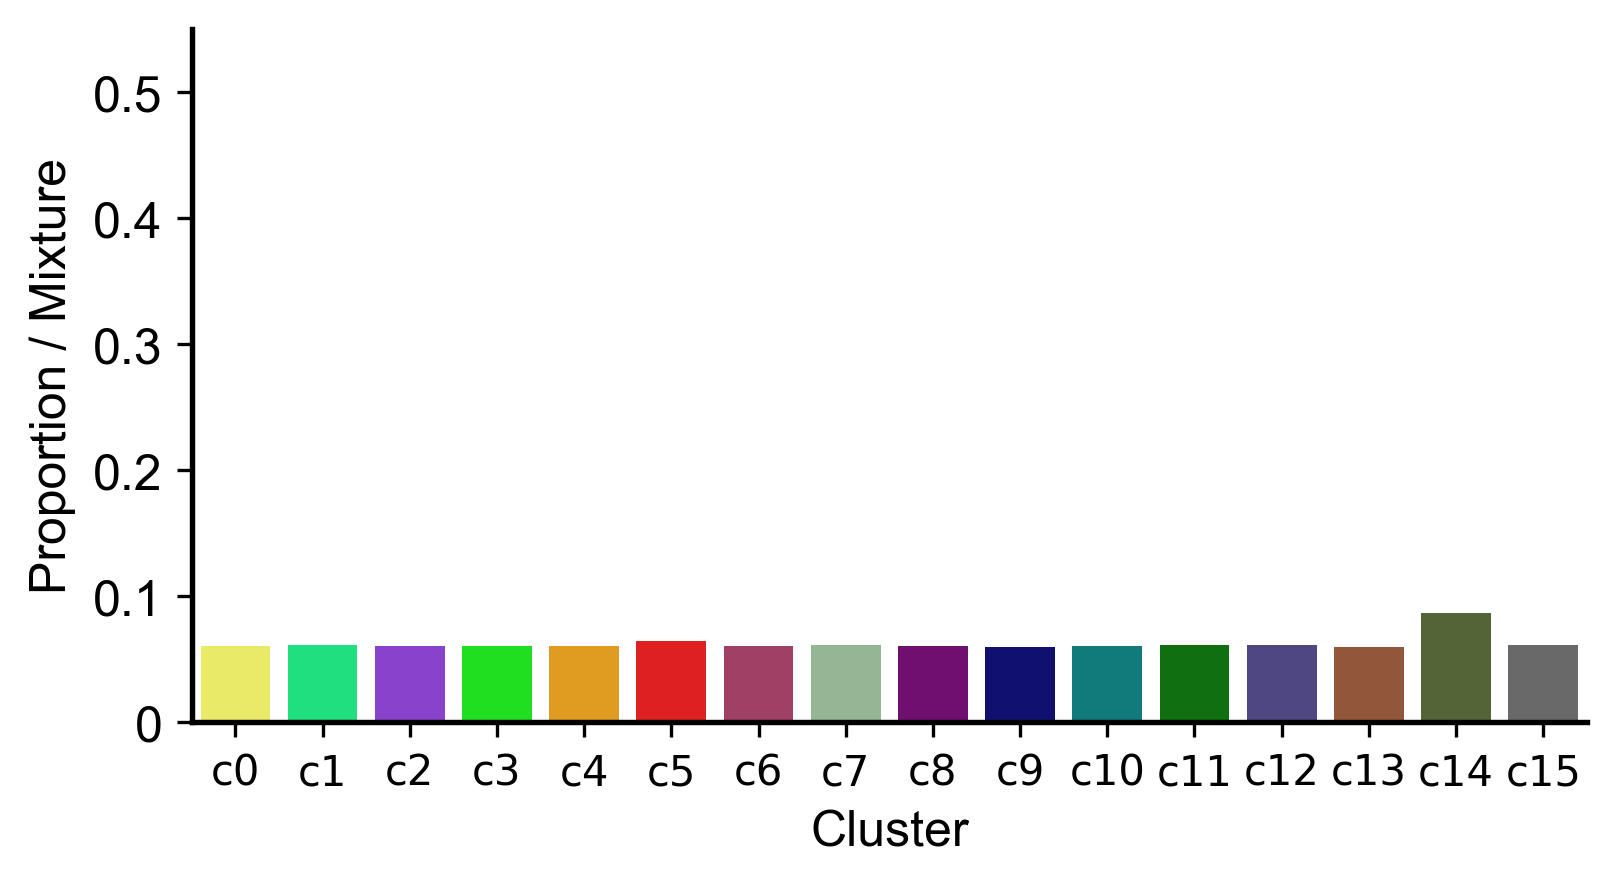

In [7]:
### open your WSI and features
slide_id = "TCGA-BP-4163-01Z-00-DX1.1dc1c4fb-2691-42f8-b62f-c51db47b30dc"
slide_fpath = f'/home/zhuzhuwen/data/svs/tcga_kirc/{slide_id}.svs'
h5_feats_fpath = f'/home/zhuzhuwen/data/features/uni/tcga_kirc/extracted_mag20x_patch256_fp/extracted-vit_large_patch16_224.dinov2.uni_mass100k/feats_h5/{slide_id}.h5'
wsi = openslide.open_slide(slide_fpath)
h5 = h5py.File(h5_feats_fpath, 'r')

# coords = h5['coords']
coords = h5['coords'][:] 
feats = torch.Tensor(h5['features'][:])
custom_downsample = 2
# patch_size = h5['coords'].attrs['patch_size'] * custom_downsample
patch_size = 256

### get PANTHER representation and GMM mixtures
with torch.inference_mode():
    out, qqs = panther_encoder.representation(feats.unsqueeze(dim=0)).values()
    tokenizer = PrototypeTokenizer(p=16, out_type='allcat')
    print("out")
    print(out.shape)
    print(out[0][0])
    print(out[0][16])
    mus, pis, sigmas = tokenizer.forward(out)
    mus = mus[0].detach().cpu().numpy()

    qq = qqs[0,:,:,0].cpu().numpy()
    global_cluster_labels = qq.argmax(axis=1)
    print("==========global_cluster_labels==========")
    from collections import Counter
    counter = Counter(global_cluster_labels)
    total_count = sum(counter.values())
    proportions = {key: count / total_count for key, count in counter.items()}
    for key, count in counter.items():
        print(f"类别: {key}, 数量: {count}, 比例: {proportions[key]:.2%}")

### Visualize the categorical heatmap and the GMM mixtures
cat_map = visualize_categorical_heatmap(
    wsi,
    coords, 
    global_cluster_labels, 
    label2color_dict=color_map,
    vis_level=wsi.get_best_level_for_downsample(128),
    patch_size=(patch_size, patch_size),
    alpha=0.4,
)


display(cat_map.resize((cat_map.width//4, cat_map.height//4)))
display(get_mixture_plot(mus, colors=list(color_map_hex.values())))

In [8]:
### Loading hallmarks + initializing cluster identities
hallmarks = pd.read_csv('<path/to//hallmarks_signatures.csv')
# hallmarks = sorted([' '.join(x[9:].split('_')) for x in hallmarks.columns])
hallmarks = sorted([' '.join(x[9:].split('_')) for x in hallmarks.columns])
cluster_ids = [f'C{i}' for i in range (16)]
cluster_identities = ['Tumor', 'Adipose/Connective', 'Connective', 'Connective', 'Adipose', 'Immune/Normal', 'Adipose/Tumor', 'Tumor', 'Tumor', 'Dense Tumor', 'Aritfacts', 'Normal Ducts/FEA', 'Dense Tumor', 'Tumor/Fat/Stroma', 'Normal', 'Tumor/Fat']
cluster_identities = dict(zip(cluster_ids, [x+' '+y for x,y in zip(cluster_ids, cluster_identities)]))

### idx corresponds to the index of the cross-attention weights that corresponds to sample_id
idx = sampleid2idx[sample_id]

### Loading cross-modal attention weights
cross_attn_path2omic = results['test']['all_cross_attn'][idx]
cross_attn_path2omic = torch.nn.Softmax(dim=1)(torch.Tensor(cross_attn_path2omic)).cpu().numpy()
cross_attn_path2omic = pd.DataFrame(cross_attn_path2omic, index=hallmarks, columns=cluster_identities.values())
print('cross_attn_path2omic shape:', cross_attn_path2omic.shape)
cross_attn_omic2path = results['test']['all_path_attn'][idx]
cross_attn_omic2path = torch.nn.Softmax(dim=1)(torch.Tensor(cross_attn_omic2path)).cpu().numpy()
cross_attn_omic2path = pd.DataFrame(cross_attn_omic2path, columns=hallmarks, index=cluster_ids)
print('cross_attn_omic2path shape:', cross_attn_omic2path.shape)
plot_dir = f'./{sample_id}/crossmodal'
os.makedirs(plot_dir, exist_ok=True)

### visualizing omic-to-path interactions
omic2path_viz = {}
for cluster in cross_attn_omic2path.index:
    omic2path = cross_attn_omic2path.loc[cluster].sort_values(ascending=False)
    omic2path_viz[cluster_identities[cluster]] = plot_pathomic_correspondence(
        omic2path, orient='v', color='#e7727a', 
        axis_lim=[0.0, 0.081], axis_tick=[0.0, 0.02, 0.04, 0.06, 0.08], lim=10)

### visualizing path-to-omic interactions
path2omic_viz = {}
for idx, omic in enumerate(cross_attn_path2omic.index):
    path2omic = cross_attn_path2omic.loc[omic].sort_values(ascending=False)
    path = os.path.join(plot_dir, f'cluster-to-hallmark{idx}-{"_".join(omic.lower().split(" "))}.png')
    path2omic_viz["_".join(omic.lower().split(" "))] = plot_pathomic_correspondence(path2omic, color='#8693e8')

FileNotFoundError: [Errno 2] No such file or directory: '<path/to//hallmarks_signatures.csv'

In [ ]:
omic2path_viz['C12 Dense Tumor']

In [ ]:
omic2path_viz['C15 Tumor/Fat']

In [ ]:
path2omic_viz['epithelial_mesenchymal_transition']

In [ ]:
path2omic_viz['tnfa_signaling_via_nfkb']